In [1]:
import os
import scipy
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from pandas import read_csv
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.io import savemat, loadmat
from scipy.stats import pointbiserialr
from matplotlib.patches import Circle
from sklearn import datasets, linear_model
from scipy.stats import probplot, pearsonr
from matplotlib.cbook import get_sample_data
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import scale 
# from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)

/Users/emilyhahn/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
preproc_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/completed'
LSS_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG'
LSS_estim_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG_estim'
censor_dir='/Users/emilyhahn/projects/msit_modeling/censor_data'
df=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})

In [3]:
# SUBJ_LIST= ['hc006','hc018','hc009','hc019','hc021','hc028','hc031','hc036','pp004','pp006','pp007','pp012','pp015']
SUBJ_LIST = ['hc001','hc002','hc003','hc004','hc005','hc006','hc010','hc011','hc012',\
             'hc014','hc015','hc017','hc019','hc021','hc023','hc028','hc031','hc032',\
             'hc033','hc034','hc036','hc038','hc042','pp001','pp002','pp003','pp004',\
             'pp006','pp007','pp008','pp010','pp011','pp012','pp013','pp015','pp016']

In [4]:
def normalize(arr): return (arr - arr.min()) / (arr.max() - arr.min())

def generate_roi_vars(roi_file,region,var):
    with open(roi_file, 'r') as file:
        for line in file:
            line=line.strip()
            line=float(line)
            if -5<line<5 and line!=0:
                region.append(line)
            else:
                region.append('NaN')
#                 print "%s beta exlcuded for %s" % (line,roi_file)
    return
def censor_tps(censor_file,censor_var,var):
    with open(censor_file, 'r') as file:
        for line in file:
            line=line.strip()
            censor_var.append(line)
#         print len(censor_var)
#         censor_var=censor_var[1::2]
#         print len(censor_var)
    return

In [5]:
for SUBJ in SUBJ_LIST:
    rt=[]
    conflict=[]
    adapt=[]
    dACC=[]
    L_IFG=[]
    R_IFG=[]
    L_dlPFC=[]
    R_dlPFC=[]
    cond=[]
    trial=[]
    acc=[]
    censor=[]
    #---------------------------------##
    ## Configure SS variables
    #---------------------------------##
    mat = loadmat(os.path.join(preproc_behav_dir,'%s_msit_ss_V2.mat') % SUBJ)
    ## Assemble Variables
    ss_outputs_xsmt = np.expand_dims(np.array([np.concatenate(arr) \
                                for arr in mat['XSmt']]).squeeze(),1)
    ss_xsmt = normalize(ss_outputs_xsmt.squeeze())
    #---------------------------------##
    rt.extend([float(i) for i in np.array(mat['RT'].squeeze())])
    conflict.extend([float(i[0]) for i in ss_xsmt])
    adapt.extend([float(i[1]) for i in ss_xsmt])
    acc.extend([float(i) for i in np.array(mat['Accuracy'].squeeze())])
    trial.extend([float(i) for i in np.array(mat['Trial'].squeeze())])
    cond.extend([float(i) for i in np.array(mat['Interference'].squeeze())])
    #---------------------------------##
    ## Configure ROI variables
    #---------------------------------##
    ## Load indiv ROI vars
    file_1=os.path.join(LSS_dir,'%s.dACC_LSS_avg_file.1D' % SUBJ)
    file_2=os.path.join(LSS_dir,'%s.L_IFG_LSS_avg_file.1D' % SUBJ)
    file_3=os.path.join(LSS_dir,'%s.R_IFG_LSS_avg_file.1D' % SUBJ)
    file_4=os.path.join(LSS_dir,'%s.L_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_5=os.path.join(LSS_dir,'%s.R_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_6=os.path.join(censor_dir,'msit.%s.msit_bsm.censor.1D' % SUBJ)
    #---------------------------------##
    ## Generate ROI variables
    generate_roi_vars(file_1,dACC,"dACC")
    generate_roi_vars(file_2,L_IFG,"L_IFG")
    generate_roi_vars(file_3,R_IFG,"R_IFG")
    generate_roi_vars(file_4,L_dlPFC,"L_dlPFC")
    generate_roi_vars(file_5,R_dlPFC,"R_dlPFC")
    censor_tps(file_6,censor,"censor")
    #---------------------------------##
    ## Determine group
    s=[]
    if 'hc' in SUBJ:
        s.append(1)
    elif 'pp' in SUBJ:
        s.append(2)
    GROUP_ARR=np.array(["%s" % s] * len(trial))
    group=[i.strip('[]') for i in GROUP_ARR]
    SUBJ_ARR=np.array(["%s" % SUBJ] * len(trial))
    #---------------------------------## 
    ## Interpolate missing ROI + RT data points
    dACC = normalize(pd.Series(dACC).astype(float).interpolate())
    R_IFG = normalize(pd.Series(R_IFG).astype(float).interpolate())
    L_IFG = normalize(pd.Series(L_IFG).astype(float).interpolate())
    L_dlPFC = normalize(pd.Series(L_dlPFC).astype(float).interpolate())
    R_dlPFC = normalize(pd.Series(R_dlPFC).astype(float).interpolate())
    rt = normalize(pd.Series(rt).astype(float).interpolate())
    #---------------------------------## 
    df1=pd.DataFrame({"group":group,"subject":SUBJ_ARR,'rt':rt,'dACC':dACC,'L_IFG':L_IFG,'R_IFG':R_IFG,'L_dlPFC':L_dlPFC,'R_dlPFC':R_dlPFC,'trial':trial,'cond':cond,'acc':acc,'conflict':conflict,'adapt':adapt})
    df=df.append(df1)
#---------------------------------##
df_hcs=df.where(df['group']=='1')
df_hcs=df_hcs.dropna()
df_pts=df.where(df['group']=='2')
df_pts=df_pts.dropna()
#---------------------------------##

In [6]:
# sns.set()
# s=sns.catplot(x="dACC",y='L_IFG',data=df,hue='group',kind='strip',ci='sd',units='subject',col="cond") 
# plt.show()

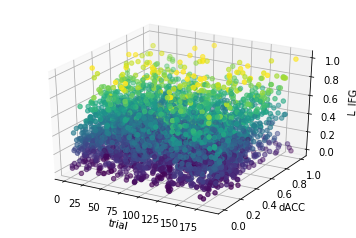

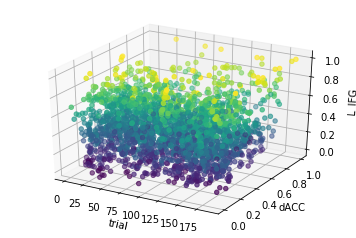

In [8]:
from mpl_toolkits import mplot3d
# import mpld3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
x = df_hcs['trial']
y = df_hcs['dACC']
z = df_hcs['L_IFG']
ax.set_xlabel('trial')
ax.set_ylabel('dACC')
ax.set_zlabel('L_IFG')
ax.scatter3D(x, y, z, c=z, cmap='viridis')

fig = plt.figure()
ax = plt.axes(projection='3d')
x = df_pts['trial']
y = df_pts['dACC']
z = df_pts['L_IFG']
ax.set_xlabel('trial')
ax.set_ylabel('dACC')
ax.set_zlabel('L_IFG')
ax.scatter3D(x, y, z, c=z, cmap='viridis')